<a href="https://colab.research.google.com/github/ramapriyakj/Quora-Duplicate-Question-Pair-Analysis/blob/master/Quora_Question_Answer_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pickle
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import unidecode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gensim

nltk.download('stopwords')
nltk.download('wordnet')
stops = set(stopwords.words('english')).union(gensim.parsing.preprocessing.STOPWORDS)
max_features = 50
pd.options.display.max_colwidth = 1000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install unidecode

In [ ]:
project_folder = '/content/drive/My Drive/Colab Notebooks/challenge/'
models_folder = project_folder+'cluster_models/'
quora_duplicate_questions = project_folder+'quora_duplicate_questions.tsv'
quora_pre_processed_file = project_folder+'quora_cluster_pre_processed'
quora_bag_of_words_file = project_folder+'quora_cluster_simple_bag_of_words'
quora_tf_idf_file = project_folder+'quora_cluster_tf_idf'
quora_lda_bow_file = project_folder+'quora_cluster_lda_bow'
quora_lda_tfidf_file = project_folder+'quora_cluster_lda_tfidf'

In [ ]:
def handle_pickle(pickle_path, operation = "read", pickle_data = None):
    if operation == "read":
        try:
            with open(pickle_path, "rb") as f:
                return pickle.load(f)
        except Exception as e:
            print("Exception in loading pickle file {} due to the following exception {}".format(pickle_path,e))
            return None
    else:
        try:
            with open(pickle_path, "wb") as f:
                pickle.dump(pickle_data,f)
        except Exception as e:
            print("Exception in dumping pickle file {} due to the following exception {}".format(pickle_path,e))
            return None

In [ ]:
def preprocess(text):
    # lower text
    text = str(text).lower()

    #unidecode text
    text = unidecode.unidecode(text)

    # handle contractions
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"ain\'t", "is not", text)
    
    # handle symbols and currencies
    text = re.sub(r"([0-9]+)000000", r"\1m", text)
    text = re.sub(r"([0-9]+)000", r"\1k", text)
    text = text.replace(",000,000", "m").replace(",000", "k").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ").replace("€", " euro ")

    # remove symbols
    text = re.sub(r"[^A-Za-z0-9]", " ", text)

    # remove whitespace
    text = re.sub(r"[\s]+", " ", text)

    # Tokenize
    text = text.split()

    # Remove stop words and lemmatize
    text_list = []
    for w in text:
        if w not in stops:
            w_ =  WordNetLemmatizer().lemmatize(w, pos='v')
            if len(w_) > 4:
                text_list.append(w_)

    text = ' '.join(text_list)
    if len(text) == 0 or len(text.split()) < 3:
        return np.nan

    return text

In [ ]:
def load_preprocessed_data(source_frame, pre_processed_file, overwrite = False):
    try:
        preprocess_data = None
        if not overwrite:
            preprocess_data = handle_pickle(pre_processed_file)
    
        if preprocess_data is None:
            preprocess_data = source_frame.copy()
            preprocess_data['processed'] = preprocess_data['question'].apply(lambda x: preprocess(x))
            preprocess_data = preprocess_data.dropna()
            handle_pickle(pre_processed_file, "write", preprocess_data)
        return preprocess_data
            
    except Exception as e:
        raise Exception("Unable to do pre processing due to exception {}".format(e))

In [ ]:
def load_features(feature_type, feature_file, source_data, max_features = 250, overwrite = False):
    try:   
        features, feature_vectorizer = None, None
        if not overwrite:
            features, feature_vectorizer = handle_pickle(feature_file)
        
        if features is None:
            if feature_type == '.bow':
                feature_vectorizer = CountVectorizer(min_df=5, max_df=0.8,max_features = max_features)
                
            elif feature_type == '.tfidf':
                feature_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8,max_features = max_features)

            feature_vectorizer.fit(source_data['processed'])
            features = feature_vectorizer.transform(source_data['processed'].values)
            handle_pickle(feature_file, "write", (features,feature_vectorizer))
        
        return features,feature_vectorizer        
    except Exception as e:
        raise Exception("Unable to generate {} features due to exception {}".format(feature_type, e))

In [ ]:
def get_features_and_predictions(feature_file, features, topics = 20, n_clusters = 5, overwrite = False):
    try:   
        lda_features = ftopics = lda_model = kmeans_model = pca_features = None
        if not overwrite:
            lda_features, ftopics, lda_model , kmeans_model, pca_features = handle_pickle(feature_file)
        
        if lda_features is None or ftopics != topics:
            scaler = StandardScaler()
            lda_model = LatentDirichletAllocation(n_components=topics, learning_method='online', random_state=42, n_jobs = -1)
            lda_features = lda_model.fit_transform(features)     
            lda_features = scaler.fit_transform(lda_features)
            kmeans_model = KMeans(n_clusters = n_clusters) 
            pca = PCA(n_components = 2)
            kmeans_model.fit(lda_features)
            pca_features = pca.fit_transform(lda_features)
            handle_pickle(feature_file, "write", (lda_features, topics, lda_model , kmeans_model, pca_features))
        return lda_features, ftopics, lda_model , kmeans_model, pca_features      
    except Exception as e:
        raise Exception("Unable to generate lda features and clusters due to exception {}".format(e))

In [ ]:
def print_five_questions_for_each_cluster(kmeans_clusters,data,feature_type):
    print("\nFive questions associated with each cluster using {} features".format(feature_type))
    clusters = np.unique(kmeans_clusters)
    for clus in clusters:
        temp_data = data.iloc[np.where(kmeans_clusters == clus)]
        print("\nCluster {} (total records = {})".format(clus,temp_data.shape[0]))
        print("-------------------------------------------------------------------------------")
        print(temp_data['question'].tail().to_string(index=False))
        print("-------------------------------------------------------------------------------")

In [ ]:
def print_topics(lda_model, feature_vectorizer, n_top_words, feature_type):
    print("\nTop {} words associated with topics generated using {} features".format(n_top_words,feature_type))
    words = feature_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda_model.components_):
        print("Topic # {} - {}".format(topic_idx, " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])))

In [ ]:
def train(lda_topics=20,topic_clusters=5,overwrite=False):

    data_source = pd.read_csv(quora_duplicate_questions,sep='\t').dropna()
    data = pd.concat((data_source['question1'],data_source['question2'])).unique()
    for i in range(5):
        np.random.seed(35)
        np.random.shuffle(data)
    data = pd.DataFrame(data,columns=['question'])
    data = data.sample(frac=0.8,random_state=42)
    del data_source
    preprocess_data = load_preprocessed_data(data, quora_pre_processed_file, overwrite)
    del data
    print("\nData set size : ",preprocess_data.shape)
    print("\nSample data : ")
    print(preprocess_data['question'].head().to_string(index=False))
    print("\nSample preprocessed data : ")
    print(preprocess_data['processed'].head().to_string(index=False))

    for model_name in ['Bag_of_words_lda','tf_idf_lda']:
        if model_name == 'Bag_of_words_lda':
            features, feature_vectorizer = load_features('.bow', quora_bag_of_words_file, preprocess_data, max_features, overwrite)
            lda_features, _, lda_model , kmeans_model, pca_features = get_features_and_predictions(quora_lda_bow_file, features, lda_topics, topic_clusters, overwrite)
        elif model_name == 'tf_idf_lda':
            features, feature_vectorizer = load_features('.tfidf', quora_tf_idf_file, preprocess_data, max_features, overwrite)
            lda_features, _, lda_model , kmeans_model, pca_features = get_features_and_predictions(quora_lda_tfidf_file, features, lda_topics, topic_clusters, overwrite)

        clus_labels = kmeans_model.labels_

        print_topics(lda_model, feature_vectorizer, 10, model_name)
        print_five_questions_for_each_cluster(kmeans_model.labels_,preprocess_data,model_name)
                
        cmap = plt.cm.get_cmap('jet')
        fig, ax = plt.subplots(figsize=(16,10))
        for i in range(topic_clusters):
            _ = ax.scatter(x=pca_features[np.where(clus_labels == i),0], y=pca_features[np.where(clus_labels == i),1], c=np.array(cmap(i/topic_clusters)).reshape(1,-1), label=i)
        ax.legend()
        plt.title(model_name+" - PCA(n_components = 2)")
        plt.xlabel('PCA-1')
        plt.ylabel('PCA-2')
        plt.show()


Data set size :  (260201, 2)

Sample data : 
                                              What are examples of things made of porcelain?
 Harvard University: Who are the most distinctive faculty in the Harvard History department?
                               How can I accurately diagnose and medicate my mental illness?
                              What's the best way to teach "Algorithms and data structures"?
                                  What is the most baffling issue in an atheistic worldview?

Sample preprocessed data : 
                                         examples things porcelain
 harvard university distinctive faculty harvard history department
                       accurately diagnose medicate mental illness
                                        teach algorithms structure
                                  baffle issue atheistic worldview

Top 10 words associated with topics generated using Bag_of_words_lda features
Topic # 0 - learn think possible service movie

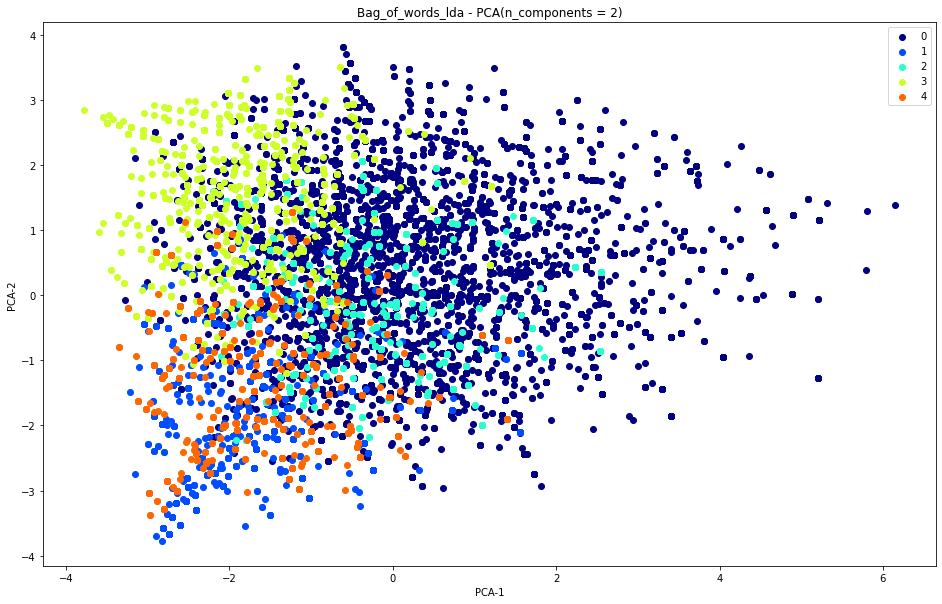


Top 10 words associated with topics generated using tf_idf_lda features
Topic # 0 - learn think possible service movie facebook science right software engineer
Topic # 1 - different university science company better engineer student state software program
Topic # 2 - people place think quora facebook right india learn better money
Topic # 3 - indian company better account software facebook service money think india
Topic # 4 - program years language learn software science possible think engineer online
Topic # 5 - world college science think student better engineer right possible place
Topic # 6 - start learn business company right service online money software india
Topic # 7 - english learn language movie write think online people indian quora
Topic # 8 - phone number possible account google service facebook software better right
Topic # 9 - happen person right facebook think possible money india trump quora
Topic # 10 - examples software science service right company business quest

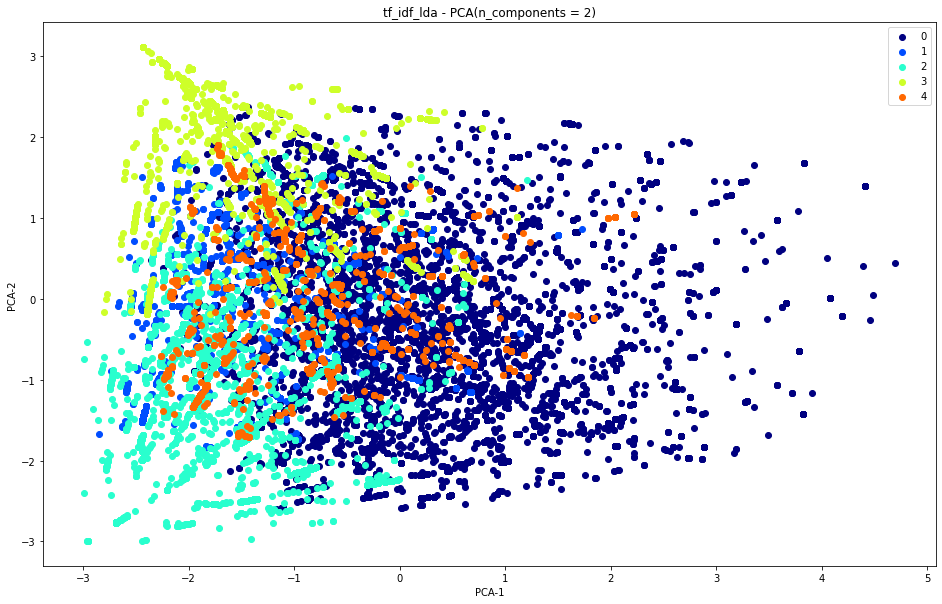

In [ ]:
train(lda_topics=20,topic_clusters=5,overwrite=True)